# LangGraph : Research Assistant with STORM

- Author: [Secludor](https://github.com/Secludor)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

Research is often a labor-intensive task delegated to analysts, but AI holds tremendous potential to revolutionize this process. This tutorial explores **how to construct a customized AI-powered research and report generation workflow** using `LangGraph`, incorporating key concepts from Stanford's STORM framework.

### Why This Approach?
The STORM methodology has demonstrated significant improvements in research quality through two key innovations:
- Outline creation through querying similar topics enhances coverage.
- Multi-perspective conversation simulation increases reference usage and information density.

The translation is accurate but can be enhanced for better clarity and technical precision. Here's the reviewed version:

### Key Components

**Core Themes**
- Memory: State management and persistence across interactions.
- Human-in-the-loop: Interactive feedback and validation mechanisms.
- Controllability: Fine-grained control over agent workflows.

**Research Framework**
- Research Automation Objective: Building customized research processes tailored to user requirements.
- Source Management: Strategic selection and integration of research input sources.
- Planning Framework: Topic definition and AI analyst team assembly.

### Process Implementation

**Execution Flow**
- LLM Integration: Conducting comprehensive expert AI interviews.
- Parallel Processing: Simultaneous information gathering and interview execution.
- Output Synthesis: Integration of research findings into comprehensive reports.

**Technical Implementation**
- Environment Setup: Configuration of runtime environment and API authentication.
- Analyst Development: Human-supervised analyst creation and validation process.
- Interview Management: Systematic question generation and response collection.
- Parallel Processing: Implementation of Map-Reduce for interview parallelization.
- Report Generation: Structured composition of introductory and concluding sections.


AI has significant potential to support these research processes. However, research requires customization. Raw LLM outputs are often not suitable for real decision-making workflows.

A customized AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflow is a promising solution to address this issue.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Utilities](#utilities)
- [Analysts Generation : Human in the Loop](#analysts-generation--human-in-the-loop)
- [Interview Execution](#interview-execution)
- [Report Writing](#report-writing)

### References

- [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag)
- [LangGraph `Send()`](https://langchain-ai.github.io/langgraph/concepts/low_level/#send)
- [LangGraph - Multi-Agent](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#custom-multi-agent-workflow)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain-anthropic",
        "langchain_community",
        "langchain_text_splitters",
        "langchain_openai",
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [3]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        }
    )

# set the project name same as the title
set_env(
    {
        "LANGCHAIN_PROJECT": "LangGraph-Research-Assistant",
    }
)

Environment variables have been set successfully.


## Utilities

These are the materials needed for the practice.

### `get_model_name`
for getting recent model name.

In [4]:
from enum import Enum


class LLMs(Enum):
    GPT4o_MINI = "gpt-4o-mini"
    GPT4o = "gpt-4o"
    GPT4 = GPT4o_MINI

    O1_PREVIEW = "o1-preview"
    O1_MINI = "o1-mini"
    O1 = O1_MINI

    CLAUDE_SONNET = "claude-3-5-sonnet-20241022"
    CLAUDE_HAIKU = "claude-3-5-haiku-20241022"
    CLAUDE = CLAUDE_SONNET

    UPSTAGE_SOLAR_MINI = "solar-mini"
    UPSTAGE_SOLAR_PRO = "solar-pro"
    UPSTAGE = UPSTAGE_SOLAR_PRO


class Embeddings(Enum):
    OPENAI_EMBEDDING_SMALL = "text-embedding-3-small"
    OPENAI_EMBEDDING_LARGE = "text-embedding-3-large"
    OPENAI_EMBEDDING = OPENAI_EMBEDDING_SMALL

    UPSTAGE_EMBEDDING_QUERY = "embedding-query"
    UPSTAGE_EMBEDDING_PASSAGE = "embedding-passage"
    UPSTAGE_EMBEDDING = UPSTAGE_EMBEDDING_PASSAGE


def get_model_name(model: LLMs | Embeddings) -> str:
    """
    Extracts and returns the final value of the model from the Enum class.

    Args:
    model (LLMs | Embeddings): An instance of the LLMs or Embeddings Enum class.

    Returns:
    str: The final value of the model. Returns None if the Enum is invalid.
    """
    try:
        # value가 Enum 멤버인 경우 최종 값을 반환
        current_value = model.value
        while isinstance(current_value, Enum):
            current_value = current_value.value
        return current_value
    except AttributeError:
        return None

### `visualize_graph`
for visualizing graph structure

In [5]:
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from dataclasses import dataclass


@dataclass
class NodeStyles:
    default: str = (
        "fill:#45C4B0, fill-opacity:0.3, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:bold, line-height:1.2"  # 기본 색상
    )
    first: str = (
        "fill:#45C4B0, fill-opacity:0.1, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"  # 점선 테두리
    )
    last: str = (
        "fill:#45C4B0, fill-opacity:1, color:#000000, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"  # 점선 테두리
    )


def visualize_graph(graph, xray=False):
    """
    Visualizes and displays the CompiledStateGraph object.

    This function converts the given graph object into a PNG image in Mermaid format and displays it, provided the graph is an instance of CompiledStateGraph.

    Args:
    graph: The graph object to visualize. It must be an instance of CompiledStateGraph.

    Returns:
    None

    Raises:
    Exception: Raises an exception if an error occurs during the graph visualization process.
    """
    try:
        if isinstance(graph, CompiledStateGraph):
            display(
                Image(
                    graph.get_graph(xray=xray).draw_mermaid_png(
                        background_color="white",
                        node_colors=NodeStyles(),
                    )
                )
            )
    except Exception as e:
        print(f"[ERROR] Visualize Graph Error: {e}")

### `random_uuid` , `invoke_graph`
- `random_uuid` : for generating a random UUID (Universally Unique Identifier) and returns it as a string.
- `invoke_graph` : for streaming and displays the results of executing a CompiledStateGraph instance in a visually appealing format. 

In [6]:
from typing import List, Callable
from langchain_core.messages import BaseMessage
from langchain_core.runnables import RunnableConfig
import uuid


def random_uuid():
    return str(uuid.uuid4())


def invoke_graph(
    graph: CompiledStateGraph,
    inputs: dict,
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable = None,
):
    """
    A function that streams and outputs the results of executing the LangGraph app in a visually appealing way.

    Args:
        graph (CompiledStateGraph): The compiled LangGraph object to execute.
        inputs (dict): A dictionary of input values to pass to the graph.
        config (RunnableConfig): The execution configuration.
        node_names (List[str], optional): A list of node names to output. Defaults to an empty list.
        callback (Callable, optional): A callback function for processing each chunk. Defaults to None.
            The callback function receives a dictionary in the format {"node": str, "content": str} as an argument.

    Returns:
        None: The function only outputs the streaming results and does not return a value.
    """

    def format_namespace(namespace):
        return namespace[-1].split(":")[0] if len(namespace) > 0 else "root graph"

    # Include output from subgraphs by setting subgraphs=True
    for namespace, chunk in graph.stream(
        inputs, config, stream_mode="updates", subgraphs=True
    ):
        for node_name, node_chunk in chunk.items():
            # Filter only if node_names is not empty
            if len(node_names) > 0 and node_name not in node_names:
                continue

            # Execute the callback function if it exists
            if callback is not None:
                callback({"node": node_name, "content": node_chunk})
            # Default output if no callback is provided
            else:
                print("\n" + "=" * 50)
                formatted_namespace = format_namespace(namespace)
                if formatted_namespace == "root graph":
                    print(f"🔄 Node: \033[1;36m{node_name}\033[0m 🔄")
                else:
                    print(
                        f"🔄 Node: \033[1;36m{node_name}\033[0m in [\033[1;33m{formatted_namespace}\033[0m] 🔄"
                    )
                print("- " * 25)

                # 노드의 청크 데이터 출력
                if isinstance(node_chunk, dict):
                    for k, v in node_chunk.items():
                        if isinstance(v, BaseMessage):
                            v.pretty_print()
                        elif isinstance(v, list):
                            for list_item in v:
                                if isinstance(list_item, BaseMessage):
                                    list_item.pretty_print()
                                else:
                                    print(list_item)
                        elif isinstance(v, dict):
                            for node_chunk_key, node_chunk_value in node_chunk.items():
                                print(f"{node_chunk_key}:\n{node_chunk_value}")
                        else:
                            print(f"\033[1;32m{k}\033[0m:\n{v}")
                else:
                    if node_chunk is not None:
                        for item in node_chunk:
                            print(item)
                print("=" * 50)

### `TabilySearch`

This code defines a tool for performing search queries using the Tavily Search API. It includes input validation, formatting of search results, and the ability to customize search parameters.
**Methods** :
- `__init__` : Initializes the TavilySearch instance, setting up the API client and input parameters.
- `_run` : Implements the base tool's run method, calling the search method and returning results.
- `search` : Performs the actual search using the Tavily API, taking various optional parameters to customize the query. It formats the output based on user preferences.
- `get_search_context` : Retrieves relevant context based on a search query, returning a JSON string that includes search results formatted as specified.

In [7]:
from langchain_core.tools import BaseTool
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing import Literal, Sequence, Optional
import json
import os
import tiktoken


class TavilySearchInput(BaseModel):
    """Input for the Tavily tool."""

    query: str = Field(description="Search Query")


def format_search_result(result: dict, include_raw_content: bool = False) -> str:
    """
    Utility functions for formatting search results.

    Args:
        result (dict): Original search results

    Returns:
        str: XML formatted search results
    """
    # use json.dumps() to treat non-english encoding
    title = json.dumps(result["title"], ensure_ascii=False)[1:-1]
    content = json.dumps(result["content"], ensure_ascii=False)[1:-1]
    raw_content = ""
    if (
        include_raw_content
        and "raw_content" in result
        and result["raw_content"] is not None
        and len(result["raw_content"].strip()) > 0
    ):
        raw_content = f"<raw>{result['raw_content']}</raw>"

    return f"<document><title>{title}</title><url>{result['url']}</url><content>{content}</content>{raw_content}</document>"


class TavilySearch(BaseTool):
    """
    Tool that queries the Tavily Search API and gets back json
    """

    name: str = "tavily_web_search"
    description: str = (
        "A search engine optimized for comprehensive, accurate, and trusted results. "
        "Useful for when you need to answer questions about current events. "
        "Input should be a search query. [IMPORTANT] Input(query) should be over 5 characters."
    )
    args_schema: type[BaseModel] = TavilySearchInput
    client: TavilyClient = None
    include_domains: list = []
    exclude_domains: list = []
    max_results: int = 3
    topic: Literal["general", "news"] = "general"
    days: int = 3
    search_depth: Literal["basic", "advanced"] = "basic"
    include_answer: bool = False
    include_raw_content: bool = True
    include_images: bool = False
    format_output: bool = False

    def __init__(
        self,
        api_key: Optional[str] = None,
        include_domains: list = [],
        exclude_domains: list = [],
        max_results: int = 3,
        topic: Literal["general", "news"] = "general",
        days: int = 3,
        search_depth: Literal["basic", "advanced"] = "basic",
        include_answer: bool = False,
        include_raw_content: bool = True,
        include_images: bool = False,
        format_output: bool = False,
    ):
        """
        Initialize TavilySearch Class

        Args:
            api_key (str): Tavily API key
            include_domains (list): A list of domains to include in the search.
            exclude_domains (list): A list of domains to exclude from the search.
            max_results (int): The maximum number of search results.
        """
        super().__init__()
        if api_key is None:
            api_key = os.environ.get("TAVILY_API_KEY", None)

        if api_key is None:
            raise ValueError("Tavily API key is not set.")

        self.client = TavilyClient(api_key=api_key)
        self.include_domains = include_domains
        self.exclude_domains = exclude_domains
        self.max_results = max_results
        self.topic = topic
        self.days = days
        self.search_depth = search_depth
        self.include_answer = include_answer
        self.include_raw_content = include_raw_content
        self.include_images = include_images
        self.format_output = format_output

    def _run(self, query: str) -> str:
        """define BaseTool's _run method"""
        results = self.search(query)
        return results
        # return json.dumps(results, ensure_ascii=False)

    def search(
        self,
        query: str,
        search_depth: Literal["basic", "advanced"] = None,
        topic: Literal["general", "news"] = None,
        days: int = None,
        max_results: int = None,
        include_domains: Sequence[str] = None,
        exclude_domains: Sequence[str] = None,
        include_answer: bool = None,
        include_raw_content: bool = None,
        include_images: bool = None,
        format_output: bool = None,
        **kwargs,
    ) -> list:
        """

        Performs a search and returns the results.

        Args:
            query (str): The search query.
            search_depth (str): The depth of the search ("basic" or "advanced").
            topic (str): The topic of the search ("general" or "news").
            days (int): The range of dates to search.
            max_results (int): The maximum number of search results.
            include_domains (list): A list of domains to include in the search.
            exclude_domains (list): A list of domains to exclude from the search.
            include_answer (bool): Whether to include an answer.
            include_raw_content (bool): Whether to include raw content.
            include_images (bool): Whether to include images.
            format_output (bool): Whether to format the results.
            **kwargs: Additional keyword arguments.

        Returns:
            list: A list of search results.
        """
        # set init values
        params = {
            "query": query,
            "search_depth": search_depth or self.search_depth,
            "topic": topic or self.topic,
            "max_results": max_results or self.max_results,
            "include_domains": include_domains or self.include_domains,
            "exclude_domains": exclude_domains or self.exclude_domains,
            "include_answer": (
                include_answer if include_answer is not None else self.include_answer
            ),
            "include_raw_content": (
                include_raw_content
                if include_raw_content is not None
                else self.include_raw_content
            ),
            "include_images": (
                include_images if include_images is not None else self.include_images
            ),
            **kwargs,
        }

        # deal `days` parameter
        if days is not None:
            if params["topic"] == "general":
                print(
                    "Warning: days parameter is ignored for 'general' topic search. Set topic parameter to 'news' to use days."
                )
            else:
                params["days"] = days

        # call API
        response = self.client.search(**params)

        # fomatting the results
        format_output = (
            format_output if format_output is not None else self.format_output
        )
        if format_output:
            return [
                format_search_result(r, params["include_raw_content"])
                for r in response["results"]
            ]
        else:
            return response["results"]

    def get_search_context(
        self,
        query: str,
        search_depth: Literal["basic", "advanced"] = "basic",
        topic: Literal["general", "news"] = "general",
        days: int = 3,
        max_results: int = 5,
        include_domains: Sequence[str] = None,
        exclude_domains: Sequence[str] = None,
        max_tokens: int = 4000,
        format_output: bool = True,
        **kwargs,
    ) -> str:
        """
        Retrieves context for the search query. This is useful for extracting only relevant content from websites,
        and you do not need to handle context extraction and limitation directly.

        Args:
            query (str): The search query.
            search_depth (str): The depth of the search ("basic" or "advanced").
            topic (str): The topic of the search ("general" or "news").
            days (int): The range of dates to search.
            max_results (int): The maximum number of search results.
            include_domains (list): A list of domains to include in the search.
            exclude_domains (list): A list of domains to exclude from the search.
            max_tokens (int): The maximum number of tokens to return (based on OpenAI token calculation). The default is 4000.
            format_output (bool): Whether to format the results.
            **kwargs: Additional keyword arguments.

        Returns:
            str: A JSON string containing the search context up to the context limit.
        """
        response = self.client.search(
            query,
            search_depth=search_depth,
            topic=topic,
            days=days,
            max_results=max_results,
            include_domains=include_domains,
            exclude_domains=exclude_domains,
            include_answer=False,
            include_raw_content=False,
            include_images=False,
            **kwargs,
        )

        sources = response.get("results", [])
        if not sources:
            return json.dumps([], ensure_ascii=False)

        # Initialize tokenizer
        encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

        # Process and accumulate results while tracking tokens
        processed_results = []
        current_tokens = 0

        for source in sources:
            if format_output:
                result = format_search_result(source, include_raw_content=False)
            else:
                result = {
                    "url": source["url"],
                    "content": json.dumps(
                        {"title": source["title"], "content": source["content"]},
                        ensure_ascii=False,
                    ),
                }

            # Convert to string to count tokens
            result_str = json.dumps(result, ensure_ascii=False)
            tokens_needed = len(encoding.encode(result_str))

            # Check if adding this result would exceed the token limit
            if current_tokens + tokens_needed > max_tokens:
                break

            processed_results.append(result)
            current_tokens += tokens_needed

        return json.dumps(processed_results, ensure_ascii=False)

## Analysts Generation : Human in the Loop
**Analyst Generation** : Create and review analysts using Human-In-The-Loop.

In [8]:
from langchain_openai import ChatOpenAI

# Get the latest model
GPT4o = get_model_name(LLMs.GPT4o)

# Initialize the model
llm = ChatOpenAI(model=GPT4o)

In [9]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field


# Class defining analyst properties and metadata
class Analyst(BaseModel):
    # Primary affiliation information
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    # Name
    name: str = Field(description="Name of the analyst.")

    # Role
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    # Description of focus, concerns, and motives
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )

    # Property that returns analyst's personal information as a string
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


# Collection of analysts
class Perspectives(BaseModel):
    # List of analysts
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

The following defines the state that tracks the collection of analysts generated through the Analyst class:

In [10]:
# State Definition
class GenerateAnalystsState(TypedDict):
    # Research topic
    topic: str
    # Maximum number of analysts to generate
    max_analysts: int
    # Human feedback
    human_analyst_feedback: str
    # List of analysts
    analysts: List[Analyst]

### Defining the Analyst Generation Node

Next, we will define the analyst generation node.

The code below implements the logic for generating various analysts based on the provided research topic. Each analyst has a unique role and affiliation, offering professional perspectives on the topic.

In [11]:
from langgraph.graph import END
from langchain_core.messages import HumanMessage, SystemMessage

# Analyst generation prompt
analyst_instructions = """You are tasked with creating a set of AI analyst personas. 

Follow these instructions carefully:
1. First, review the research topic:

{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide the creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and/or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""


# Analyst generation node
def create_analysts(state: GenerateAnalystsState):
    """Function to create analyst personas"""

    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    # Apply structured output format to LLM
    structured_llm = llm.with_structured_output(Perspectives)

    # Construct system prompt for analyst creation
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts,
    )

    # Call LLM to generate analyst personas
    analysts = structured_llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="Generate the set of analysts.")]
    )

    # Store generated list of analysts in state
    return {"analysts": analysts.analysts}


# User feedback node (can be left empty since it will update state)
def human_feedback(state: GenerateAnalystsState):
    """A checkpoint node for receiving user feedback"""
    pass


# Function to decide the next step in the workflow based on human feedback
def should_continue(state: GenerateAnalystsState):
    """Function to determine the next step in the workflow"""

    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"

    return END

**Explanation of Code Components**

- **Analyst Instructions**: A prompt that guides the LLM in creating AI analyst personas based on a specified research topic and any provided feedback.

- **create_analysts Function**: This function is responsible for generating a set of analysts based on the current state, which includes the research topic, maximum number of analysts, and any human feedback.

- **human_feedback Function**: A placeholder function that can be expanded to handle user feedback.

- **should_continue Function**: This function evaluates whether there is human feedback available and determines whether to proceed with creating analysts or end the process. 

This structure allows for a dynamic approach to generating tailored analyst personas that can provide diverse insights into a given research topic.

### Building the Analyst Generation Graph

Now we'll create the analyst generation graph that orchestrates the research workflow.

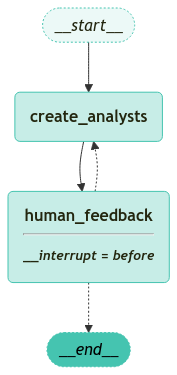

In [12]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Create graph
builder = StateGraph(GenerateAnalystsState)

# Add nodes
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

# Connect edges
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")

# Add conditional edge: return to analyst creation node if human feedback exists
builder.add_conditional_edges(
    "human_feedback", should_continue, ["create_analysts", END]
)

# Create memory
memory = MemorySaver()

# Compile graph (set breakpoints)
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# Visualize graph
visualize_graph(graph)

**Graph Components**

- **Nodes**
    - `create_analysts`: Generates analyst personas based on the research topic
    - `human_feedback`: Checkpoint for receiving user input and feedback

- **Edges**
    - Initial flow from START to analyst creation
    - Connection from analyst creation to human feedback
    - Conditional path back to analyst creation based on feedback

- **Features**
    - Memory persistence using `MemorySaver`
    - Breakpoints before human feedback collection
    - Visual representation of workflow through `visualize_graph`

This graph structure enables an iterative research process with human oversight and feedback integration.

### Running the Analyst Generation Graph
Here's how to execute and manage the analyst generation workflow:

In [13]:
from langchain_core.runnables import RunnableConfig

# Configure graph execution settings
config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": random_uuid()},
)

# Set number of analysts
max_analysts = 3

# Define research topic
topic = "What are the differences between Modular RAG and Naive RAG, and what are the benefits of using it at the production level"

# Configure input parameters
inputs = {
    "topic": topic,
    "max_analysts": max_analysts,
}

# Execute graph
invoke_graph(graph, inputs, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='Tech Research Institute' name='Dr. Emma Hughes' role='RAG System Architect' description='Dr. Hughes specializes in designing and implementing RAG systems. Her focus is on understanding the architectural differences between Modular RAG and Naive RAG, particularly in terms of scalability and integration within existing infrastructures. She is motivated by optimizing RAG systems for better performance and reliability at the production level.'
affiliation='Data Science Innovations Ltd.' name='Mr. Alex Chen' role='AI Performance Analyst' description='Mr. Chen focuses on evaluating the performance metrics of AI systems. His primary concern is comparing the efficiency and effectiveness of Modular RAG versus Naive RAG in real-world applications. He aims to identify how these differences impact computational resources and processing speed in production environments.'
affiliation='Enterprise Solutions Grou

When `__interrupt__` is displayed, the system is ready to receive human feedback. At this point, you can retrieve the current state and provide feedback to guide the analyst generation process.

In [14]:
# Get current graph state
state = graph.get_state(config)

# Check next node
print(state.next)

('human_feedback',)


To inject human feedback into the graph, we use the `update_state` method with the following key components:

In [15]:
# Update graph state with human feedback
graph.update_state(
    config,
    {
        "human_analyst_feedback": "Add in someone named Teddy Lee from a startup to add an entrepreneur perspective"
    },
    as_node="human_feedback",
)

{'configurable': {'thread_id': '55d4904e-7a73-438a-ad4b-0196d893850b',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd8ce8-34da-64cc-8002-10289c286479'}}

**Key Parameters**
- `config` : Configuration object containing graph settings
- `human_analyst_feedback` : Key for storing feedback content
- `as_node` : Specifies the node that will process the feedback

**[Note]** : Assigning `None` as input triggers the graph to continue its execution from the last checkpoint. This is particularly useful when you want to resume processing after providing human feedback.

(Continue) To resume the graph execution after the `__interrupt__` :

In [16]:
# Continue execution
invoke_graph(graph, None, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='Tech Startup' name='Teddy Lee' role='Entrepreneur' description='Focuses on the practical applications and business implications of adopting Modular RAG versus Naive RAG in startup environments. Concerned with scalability, cost-effectiveness, and innovation potential to maintain a competitive edge.'
affiliation='University of Technology' name='Dr. Emily Foster' role='Academic Researcher' description='Explores the theoretical differences between Modular RAG and Naive RAG, emphasizing the technical nuances and potential for innovation. Interested in how these models can be leveraged for research and educational purposes.'
affiliation='Global Tech Corporation' name='Michael Chen' role='Industry Expert' description='Analyzes the benefits and challenges of implementing Modular RAG at the production level in large enterprises. Focuses on operational efficiency, integration into existing systems, and lon

When `__interrupt__` appears again, you have two options: 

- Option 1: Provide Additional Feedback
    - You can provide more feedback to further refine the analyst personas using the same method as before
- Option 2: Complete the Process

To finish the analyst generation process without additional feedback:

In [17]:
# Set feedback input to None to indicate completion
human_feedback_input = None

# Update graph state with no feedback
graph.update_state(
    config, {"human_analyst_feedback": human_feedback_input}, as_node="human_feedback"
)

{'configurable': {'thread_id': '55d4904e-7a73-438a-ad4b-0196d893850b',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd8ce8-5fb0-66f1-8004-77359540a17e'}}

In [18]:
# Continue final execution
invoke_graph(graph, None, config)

**Displaying Final Results**

Get and display the final results from the graph:

In [19]:
# Get final state
final_state = graph.get_state(config)

# Get generated analysts
analysts = final_state.values.get("analysts")

# Print analyst count
print(
    f"Number of analysts generated: {len(analysts)}",
    end="\n================================\n",
)

# Print each analyst's persona
for analyst in analysts:
    print(analyst.persona)
    print("- " * 30)

# Get next node state (empty tuple indicates completion)
print(final_state.next)

Number of analysts generated: 3
Name: Teddy Lee
Role: Entrepreneur
Affiliation: Tech Startup
Description: Focuses on the practical applications and business implications of adopting Modular RAG versus Naive RAG in startup environments. Concerned with scalability, cost-effectiveness, and innovation potential to maintain a competitive edge.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Name: Dr. Emily Foster
Role: Academic Researcher
Affiliation: University of Technology
Description: Explores the theoretical differences between Modular RAG and Naive RAG, emphasizing the technical nuances and potential for innovation. Interested in how these models can be leveraged for research and educational purposes.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Name: Michael Chen
Role: Industry Expert
Affiliation: Global Tech Corporation
Description: Analyzes the benefits and challenges of implementing Modular RAG at the production level in large enterprises. Focuses on

**Key Components**
- `final_state`: Contains the final state of the graph execution.
- `analysts`: List of generated analyst personas.
- `final_state.next`: Empty tuple indicating workflow completion.

The output will display each analyst's complete persona information, including their name, role, affiliation, and description, followed by a separator line. The empty tuple printed at the end confirms that the graph execution has completed successfully.

## Interview Execution

### Define Classes and `question_generation` Node
Let's implement the interview execution components with proper state management and `question_generation` Node:

In [20]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState


class InterviewState(MessagesState):
    """State management for interview process"""

    max_num_turns: int
    context: Annotated[list, operator.add]  # Context list containing source documents
    analyst: Analyst
    interview: str  # String storing interview content
    sections: list  # List of report sections


class SearchQuery(BaseModel):
    """Data class for search queries"""

    search_query: str = Field(None, description="Search query for retrieval.")

In [21]:
def generate_question(state: InterviewState):
    """Node for generating interview questions"""

    # System prompt for question generation
    question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

    Your goal is boil down to interesting and specific insights related to your topic.

    1. Interesting: Insights that people will find surprising or non-obvious.
            
    2. Specific: Insights that avoid generalities and include specific examples from the expert.

    Here is your topic of focus and set of goals: {goals}
            
    Begin by introducing yourself using a name that fits your persona, and then ask your question.

    Continue to ask questions to drill down and refine your understanding of the topic.
            
    When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

    Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

    # Extract state components
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question using LLM
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + messages)

    # Return updated messages
    return {"messages": [question]}

**State Management**
- `InterviewState` tracks conversation turns, context, and interview content.
- Annotated context list allows for document accumulation.
- Maintains analyst persona and report sections.

**Question Generation**
- Structured system prompt for consistent interviewing style.
- Persona-aware questioning based on analyst goals.
- Progressive refinement of topic understanding.
- Clear interview conclusion mechanism.

The code provides a robust foundation for conducting structured interviews while maintaining conversation state and context.

### Defining Research Tools

Experts collect information in parallel from multiple sources to answer questions.

They can utilize various tools such as web document scraping, VectorDB, web search, and Wikipedia search.

We'll focus on two main tools: **`Tavily`** for web search and **`ArxivRetriever`** for academic papers.

`Tavily Search`
- Real-time web search capabilities
- Configurable result count and content depth
- Structured output formatting
- Raw content inclusion option

In [22]:
# Initialize TavilySearch with configuration
tavily_search = TavilySearch(max_results=3)

`ArxivRetriever`
- Access to academic papers and research
- Full document retrieval
- Comprehensive metadata access
- Customizable document load limits

In [23]:
from langchain_community.retrievers import ArxivRetriever

# Initialize ArxivRetriever with configuration
arxiv_retriever = ArxivRetriever(
    load_max_docs=3, load_all_available_meta=True, get_full_documents=True
)

# Execute arxiv search and print results
arxiv_search_results = arxiv_retriever.invoke("Modular RAG vs Naive RAG")
print(arxiv_search_results)

[Document(metadata={'Published': '2024-07-26', 'Title': 'Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks', 'Authors': 'Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang', 'Summary': 'Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities\nof Large Language Models (LLMs) in tackling knowledge-intensive tasks. The\nincreasing demands of application scenarios have driven the evolution of RAG,\nleading to the integration of advanced retrievers, LLMs and other complementary\ntechnologies, which in turn has amplified the intricacy of RAG systems.\nHowever, the rapid advancements are outpacing the foundational RAG paradigm,\nwith many methods struggling to be unified under the process of\n"retrieve-then-generate". In this context, this paper examines the limitations\nof the existing RAG paradigm and introduces the modular RAG framework. By\ndecomposing complex RAG systems into independent modules and specialized\noperators, it facilitates a high

In [24]:
# metadata of Arxiv
arxiv_search_results[0].metadata

{'Published': '2024-07-26',
 'Title': 'Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks',
 'Authors': 'Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang',
 'Summary': 'Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities\nof Large Language Models (LLMs) in tackling knowledge-intensive tasks. The\nincreasing demands of application scenarios have driven the evolution of RAG,\nleading to the integration of advanced retrievers, LLMs and other complementary\ntechnologies, which in turn has amplified the intricacy of RAG systems.\nHowever, the rapid advancements are outpacing the foundational RAG paradigm,\nwith many methods struggling to be unified under the process of\n"retrieve-then-generate". In this context, this paper examines the limitations\nof the existing RAG paradigm and introduces the modular RAG framework. By\ndecomposing complex RAG systems into independent modules and specialized\noperators, it facilitates a highly reconfigurabl

In [25]:
# content of Arxiv
print(arxiv_search_results[0].page_content)

1
Modular RAG: Transforming RAG Systems into
LEGO-like Reconfigurable Frameworks
Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang
Abstract—Retrieval-augmented
Generation
(RAG)
has
markedly enhanced the capabilities of Large Language Models
(LLMs) in tackling knowledge-intensive tasks. The increasing
demands of application scenarios have driven the evolution
of RAG, leading to the integration of advanced retrievers,
LLMs and other complementary technologies, which in turn
has amplified the intricacy of RAG systems. However, the rapid
advancements are outpacing the foundational RAG paradigm,
with many methods struggling to be unified under the process
of “retrieve-then-generate”. In this context, this paper examines
the limitations of the existing RAG paradigm and introduces
the modular RAG framework. By decomposing complex RAG
systems into independent modules and specialized operators, it
facilitates a highly reconfigurable framework. Modular RAG
transcends the traditional linear architect

 format and display Arxiv search results in a structured XML-like format:

In [26]:
# 문서 검색 결과를 포맷팅
formatted_search_docs = "\n\n---\n\n".join(
    [
        f'<Document source="{doc.metadata["entry_id"]}" date="{doc.metadata.get("Published", "")}" authors="{doc.metadata.get("Authors", "")}"/>\n<Title>\n{doc.metadata["Title"]}\n</Title>\n\n<Summary>\n{doc.metadata["Summary"]}\n</Summary>\n\n<Content>\n{doc.page_content}\n</Content>\n</Document>'
        for doc in arxiv_search_results
    ]
)

In [27]:
print(formatted_search_docs)

<Document source="http://arxiv.org/abs/2407.21059v1" date="2024-07-26" authors="Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang"/>
<Title>
Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks
</Title>

<Summary>
Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities
of Large Language Models (LLMs) in tackling knowledge-intensive tasks. The
increasing demands of application scenarios have driven the evolution of RAG,
leading to the integration of advanced retrievers, LLMs and other complementary
technologies, which in turn has amplified the intricacy of RAG systems.
However, the rapid advancements are outpacing the foundational RAG paradigm,
with many methods struggling to be unified under the process of
"retrieve-then-generate". In this context, this paper examines the limitations
of the existing RAG paradigm and introduces the modular RAG framework. By
decomposing complex RAG systems into independent modules and specialized
operators, it fa

### Defining Search Tool Nodes

The code implements two main search tool nodes for gathering research information: web search via `Tavily` and academic paper search via `ArXiv`. Here's a breakdown of the key components:

In [28]:
from langchain_core.messages import SystemMessage

# Search query instruction
search_instructions = SystemMessage(
    content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query"""
)


def search_web(state: InterviewState):
    """Performs web search using Tavily"""

    # Generate search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    # Execute search
    search_docs = tavily_search.invoke(search_query.search_query)

    # Format results - handle both string and dict responses
    if isinstance(search_docs, list):
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
                for doc in search_docs
            ]
        )

    return {"context": [formatted_search_docs]}


def search_arxiv(state: InterviewState):
    """Performs academic paper search using ArXiv"""

    # Generate search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    try:
        # Execute search
        arxiv_search_results = arxiv_retriever.invoke(
            search_query.search_query,
            load_max_docs=2,
            load_all_available_meta=True,
            get_full_documents=True,
        )

        # Format results
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document source="{doc.metadata["entry_id"]}" date="{doc.metadata.get("Published", "")}" authors="{doc.metadata.get("Authors", "")}"/>\n<Title>\n{doc.metadata["Title"]}\n</Title>\n\n<Summary>\n{doc.metadata["Summary"]}\n</Summary>\n\n<Content>\n{doc.page_content}\n</Content>\n</Document>'
                for doc in arxiv_search_results
            ]
        )

        return {"context": [formatted_search_docs]}
    except Exception as e:
        print(f"ArXiv search error: {str(e)}")
        return {"context": ["<Error>Failed to retrieve ArXiv search results.</Error>"]}

**Key Features**
- Query Generation: Uses LLM to create structured search queries from conversation context
- Error Handling: Robust error management for ArXiv searches
- Result Formatting: Consistent XML-style formatting for both web and academic results
- Metadata Integration: Comprehensive metadata inclusion for academic papers
- State Management: Maintains conversation context through InterviewState

### Define `generate_answer`, `save_interview`, `route_messages`, `write_section` Nodes

- The `generate_answer` node is responsible for creating expert responses during the interview process.

In [29]:
from langchain_core.messages import get_buffer_string
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""


def generate_answer(state: InterviewState):
    """Generates expert responses to analyst questions"""

    # Get analyst and messages from state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Generate answer for the question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)

    # Name the message as expert response
    answer.name = "expert"

    # Add message to state
    return {"messages": [answer]}

- `save_interview`

In [30]:
def save_interview(state: InterviewState):
    """Saves the interview content"""

    # Get messages from state
    messages = state["messages"]

    # Convert interview to string
    interview = get_buffer_string(messages)

    # Store under interview key
    return {"interview": interview}

### Define `generate_answer`, `save_interview`, `route_messages`, `write_section` Nodes
- `route_messages`

In [31]:
def route_messages(state: InterviewState, name: str = "expert"):
    """Routes between questions and answers in the conversation"""

    # Get messages from state
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    # Count expert responses
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End interview if maximum turns reached
    if num_responses >= max_num_turns:
        return "save_interview"

    # This router runs after each question-answer pair
    # Get the last question to check for conversation end signal
    last_question = messages[-2]

    # Check for conversation end signal
    if "Thank you so much for your help" in last_question.content:
        return "save_interview"
    return "ask_question"

- The `write_section` function and its associated instructions implement a structured report generation system.

In [32]:
section_writer_instructions = """You are an expert technical writer. 

Your task is to create a detailed and comprehensive section of a report, thoroughly analyzing a set of source documents.
This involves extracting key insights, elaborating on relevant points, and providing in-depth explanations to ensure clarity and understanding. Your writing should include necessary context, supporting evidence, and examples to enhance the reader's comprehension. Maintain a logical and well-organized structure, ensuring that all critical aspects are covered in detail and presented in a professional tone.

Please follow these instructions:
1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Comprehensive analysis (### header)
d. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. For the Comprehensive analysis section:
- Provide a detailed examination of the information from the source documents.
- Break down complex ideas into digestible segments, ensuring a logical flow of ideas.
- Use sub-sections where necessary to cover multiple perspectives or dimensions of the analysis.
- Support your analysis with data, direct quotes, and examples from the source documents.
- Clearly explain the relevance of each point to the overall focus of the report.
- Use bullet points or numbered lists for clarity when presenting multiple related ideas.
- Ensure the tone remains professional and objective, avoiding bias or unsupported opinions.
- Aim for at least 800 words to ensure the analysis is thorough.

7. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

8. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
9. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""


def write_section(state: InterviewState):
    """Generates a structured report section based on interview content"""

    # Get context and analyst from state
    context = state["context"]
    analyst = state["analyst"]

    # Define system prompt for section writing
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke(
        [
            SystemMessage(content=system_message),
            HumanMessage(content=f"Use this source to write your section: {context}"),
        ]
    )

    # Add section to state
    return {"sections": [section.content]}

### Building the Interview Graph
Here's how to create and configure the interview execution graph:

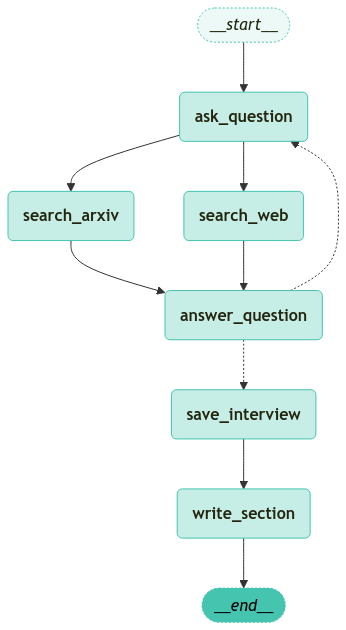

In [33]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Add nodes and edges
interview_builder = StateGraph(InterviewState)

# Define nodes
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_arxiv", search_arxiv)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Configure flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_arxiv")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_arxiv", "answer_question")
interview_builder.add_conditional_edges(
    "answer_question", route_messages, ["ask_question", "save_interview"]
)
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Create interview graph with memory
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(
    run_name="Conduct Interviews"
)

# Visualize the graph
visualize_graph(interview_graph)

**Graph Structure**

The interview process follows this flow:
1. Question Generation
2. Parallel Search (Web and ArXiv)
3. Answer Generation
4. Conditional Routing
5. Interview Saving
6. Section Writing

**Key Components**
- State Management: Uses InterviewState for tracking
- Memory Persistence: Implements MemorySaver
- Conditional Logic: Routes between questions and interview completion
- Parallel Processing: Conducts simultaneous web and academic searches

Note: Ensure the langgraph module is installed before running this code.

### Executing the Interview Graph
Here's how to execute the graph and display the results:

In [34]:
# Select first analyst from the list
analysts[0]

Analyst(affiliation='Tech Startup', name='Teddy Lee', role='Entrepreneur', description='Focuses on the practical applications and business implications of adopting Modular RAG versus Naive RAG in startup environments. Concerned with scalability, cost-effectiveness, and innovation potential to maintain a competitive edge.')

In [35]:
from IPython.display import Markdown

# Set research topic
topic = "What are the differences between Modular RAG and Naive RAG, and what are the benefits of using it at production level"

# Create initial interview message
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]

# Configure thread ID
config = RunnableConfig(
    recursion_limit=100,
    configurable={"thread_id": random_uuid()},
)

# Execute graph
invoke_graph(
    interview_graph,
    {"analyst": analysts[0], "messages": messages, "max_num_turns": 5},
    config,
)


🔄 Node: ask_question 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Hello, I'm Alex Carter, a tech industry analyst. I'm keen to dive into the practical applications and business implications of adopting Modular RAG versus Naive RAG, particularly in a startup environment. Given your expertise, could you start by explaining the fundamental differences between Modular RAG and Naive RAG, especially in terms of scalability and cost-effectiveness?

🔄 Node: search_web 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<Document href="https://adasci.org/how-does-modular-rag-improve-upon-naive-rag/"/>
The consolidated table demonstrates that Modular RAG outperforms Naive RAG across all key metrics, making it a more effective and reliable solution for customer support chatbots. By adopting a modular approach, organizations can achieve better relevance, faster response times, greater scalability, and highe

Display completed interview section in markdown

In [36]:
Markdown(interview_graph.get_state(config).values["sections"][0])

## Modular RAG vs. Naive RAG: Business Implications for Startups

### Summary

In the rapidly advancing field of artificial intelligence, the adoption of Retrieval-Augmented Generation (RAG) systems has become a focal point for startups aiming to leverage large language models (LLMs) for their business operations. Specifically, the transition from Naive RAG to Modular RAG presents significant opportunities for scalability, cost-effectiveness, and innovation, essential for maintaining a competitive edge. The analysis of recent studies and theoretical frameworks reveals intriguing insights into the practical applications and business implications of these systems, particularly in startup environments. This report synthesizes the findings from several key documents, highlighting novel methodologies and the transformative potential of Modular RAG.

1. **A Theory for Token-Level Harmonization in Retrieval-Augmented Generation** [1]: This document introduces a theoretical framework for understanding the benefit and detriment dynamics in RAG systems, proposing a novel Tok-RAG method that enhances token-level generation.

2. **Towards Fair RAG: On the Impact of Fair Ranking in Retrieval-Augmented Generation** [2]: This paper explores the integration of fair ranking within RAG systems, emphasizing the balance between fairness and quality in content generation.

3. **RAG-DDR: Optimizing Retrieval-Augmented Generation Using Differentiable Data Rewards** [3]: Presents a Differentiable Data Rewards method to optimize RAG systems, showcasing improved alignment of data preferences across RAG modules.

4. **Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks** [4]: Introduces the modular RAG framework, highlighting its ability to decompose RAG systems into independent, reconfigurable modules.

5. **How Does Modular RAG Improve Upon Naive RAG?** [5]: Discusses the advantages of Modular RAG in terms of relevance, response time, scalability, and customer satisfaction, particularly in customer support applications.

6. **A Comprehensive Guide to Implementing Modular RAG for Scalable AI Systems** [6]: Provides a detailed exploration of Modular RAG's foundational principles and practical implementation strategies, tailored for enterprise scalability.

These documents collectively contribute to a deeper understanding of how Modular RAG can fundamentally alter the landscape for startups by offering more flexible, efficient, and scalable AI solutions.

### Comprehensive Analysis

#### Theoretical Foundations and Practical Applications

1. **Theoretical Advancements in RAG** [1]:
   - The introduction of a theoretical framework for RAG, focusing on the balance between benefit and detriment, addresses the core challenges faced by startups using RAG systems. The Tok-RAG method enhances token-level generation by predicting the net effect of RAG without additional training, offering a cost-effective solution for startups.

2. **Fairness in RAG Systems** [2]:
   - The integration of fair ranking mechanisms into RAG systems highlights the importance of equitable content exposure. For startups, especially those in content generation and customer service, ensuring fairness can lead to higher satisfaction and trust among users. The findings suggest that fair RAG systems can outperform traditional ones by maintaining high generation quality.

#### Optimization and Performance Enhancement

3. **Optimization through Differentiable Data Rewards (DDR)** [3]:
   - The DDR method significantly improves RAG systems by aligning data preferences and enhancing retrieval accuracy. This method is particularly beneficial for startups with limited computational resources, as it optimizes the performance of smaller-scale LLMs that rely heavily on retrieved knowledge.

4. **Modular RAG: A Leap Forward** [4], [5]:
   - Modular RAG introduces a reconfigurable framework, enabling startups to decompose and reassemble RAG systems as needed. This flexibility allows for targeted improvements, such as enhancing retrieval mechanisms or optimizing generation modules. The modular approach not only improves system efficiency but also facilitates innovation by allowing startups to experiment with different configurations.

5. **Scalability and Implementation Strategies** [6]:
   - By decoupling retrieval, reasoning, and generation, Modular RAG systems enable startups to scale AI solutions efficiently. The guide provides practical strategies for implementing these systems, emphasizing the importance of a modular architecture in managing large datasets and adapting to evolving business needs.

#### Business Implications and Innovation Potential

- **Scalability and Cost-Effectiveness**:
  - Modular RAG offers startups the ability to scale specific components based on demand, optimizing resource allocation and reducing costs. This selective scaling is crucial for startups that must balance growth with financial constraints.

- **Competitive Edge through Innovation**:
  - The flexibility of Modular RAG allows startups to innovate rapidly, adapting to market changes and developing new products or services. This adaptability is essential for maintaining a competitive edge in the fast-paced tech industry.

- **Customer Satisfaction and Market Adaptation**:
  - Enhanced relevance and response times, as demonstrated by Modular RAG, lead to higher customer satisfaction. Startups can leverage this advantage to improve customer support and engagement, ultimately driving business success.

Overall, the transition from Naive to Modular RAG systems represents a significant advancement for startups, providing a framework for scalable, cost-effective, and innovative AI solutions that can drive business growth and competitive advantage.

### Sources
[1] http://arxiv.org/abs/2406.00944v2  
[2] http://arxiv.org/abs/2409.11598v2  
[3] http://arxiv.org/abs/2410.13509v1  
[4] http://arxiv.org/abs/2407.21059v1  
[5] https://adasci.org/how-does-modular-rag-improve-upon-naive-rag/  
[6] https://medium.com/aingineer/a-comprehensive-guide-to-implementing-modular-rag-for-scalable-ai-systems-3fb47c46dc8e  

In [37]:
print(interview_graph.get_state(config).values["sections"][0])

## Modular RAG vs. Naive RAG: Business Implications for Startups

### Summary

In the rapidly advancing field of artificial intelligence, the adoption of Retrieval-Augmented Generation (RAG) systems has become a focal point for startups aiming to leverage large language models (LLMs) for their business operations. Specifically, the transition from Naive RAG to Modular RAG presents significant opportunities for scalability, cost-effectiveness, and innovation, essential for maintaining a competitive edge. The analysis of recent studies and theoretical frameworks reveals intriguing insights into the practical applications and business implications of these systems, particularly in startup environments. This report synthesizes the findings from several key documents, highlighting novel methodologies and the transformative potential of Modular RAG.

1. **A Theory for Token-Level Harmonization in Retrieval-Augmented Generation** [1]: This document introduces a theoretical framework for under

### Parallel Interviewing by `map-reduce`
Here's how to implement parallel interviews using map-reduce in LangGraph:

In [38]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict


class ResearchGraphState(TypedDict):
    """State definition for research graph"""

    # Research topic
    topic: str
    # Maximum number of analysts
    max_analysts: int
    # Human analyst feedback
    human_analyst_feedback: str
    # List of questioning analysts
    analysts: List[Analyst]
    # List of sections containing Send() API keys
    sections: Annotated[list, operator.add]
    # Report components
    introduction: str
    content: str
    conclusion: str
    final_report: str

Let me explain how the `Send()` function is used in LangGraph for parallel interview execution:

**Reference**
- [LangGraph `Send()`](https://langchain-ai.github.io/langgraph/concepts/low_level/#send)

In [39]:
from langgraph.constants import Send


def initiate_all_interviews(state: ResearchGraphState):
    """Initiates parallel interviews for all analysts"""

    # Check for human feedback
    human_analyst_feedback = state.get("human_analyst_feedback")

    # Return to analyst creation if human feedback exists
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise, initiate parallel interviews using Send()
    else:
        topic = state["topic"]
        return [
            Send(
                "conduct_interview",
                {
                    "analyst": analyst,
                    "messages": [
                        HumanMessage(
                            content=f"So you said you were writing an article on {topic}?"
                        )
                    ],
                },
            )
            for analyst in state["analysts"]
        ]

## Report Writing

Next, we will define the guidelines for writing a report based on the interview content and define a function for report writing.

### Define Nodes
- Main Report Content

In [40]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.  
2. Carefully review and analyze the insights from each memo.  
3. Consolidate these insights into a detailed and comprehensive summary that integrates the central ideas from all the memos.  
4. Organize the key points from each memo into the appropriate sections provided below, ensuring that each section is logical and well-structured.  
5. Include all required sections in your report, using `### Section Name` as the header for each.  
6. Aim for approximately 250 words per section, providing in-depth explanations, context, and supporting details.  

**Sections to consider (including optional ones for greater depth):**

- **Background**: Theoretical foundations, key concepts, and preliminary information necessary to understand the methodology and results.
- **Related Work**: Overview of prior studies and how they compare or relate to the current research.
- **Problem Definition**: A formal and precise definition of the research question or problem the paper aims to address.
- **Methodology (or Methods)**: Detailed description of the methods, algorithms, models, data collection processes, or experimental setups used in the study.
- **Implementation Details**: Practical details of how the methods or models were implemented, including software frameworks, computational resources, or parameter settings.
- **Experiments**: Explanation of experimental protocols, datasets, evaluation metrics, procedures, and configurations employed to validate the methods.
- **Results**: Presentation of experimental outcomes, often with statistical tables, graphs, figures, or qualitative analyses.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""


def write_report(state: ResearchGraphState):
    """Generates main report content from interview sections"""
    sections = state["sections"]
    topic = state["topic"]

    # Combine all sections
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Generate report from sections
    system_message = report_writer_instructions.format(
        topic=topic, context=formatted_str_sections
    )
    report = llm.invoke(
        [
            SystemMessage(content=system_message),
            HumanMessage(content="Write a report based upon these memos."),
        ]
    )
    return {"content": report.content}

- Introduction Generation

In [41]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 200 words, crisply previewing (for introduction),  or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


def write_introduction(state: ResearchGraphState):
    """Creates report introduction"""
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    intro = llm.invoke(
        [instructions, HumanMessage(content="Write the report introduction")]
    )
    return {"introduction": intro.content}


def write_conclusion(state: ResearchGraphState):
    """Creates report conclusion"""
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    conclusion = llm.invoke(
        [instructions, HumanMessage(content="Write the report conclusion")]
    )
    return {"conclusion": conclusion.content}

- Final Report Assembly

In [42]:
def finalize_report(state: ResearchGraphState):
    """Assembles final report with all components"""
    content = state["content"]

    # Clean up content formatting
    if content.startswith("## Insights"):
        content = content.strip("## Insights")

    # Handle sources section
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    # Assemble final report
    final_report = (
        state["introduction"]
        + "\n\n---\n\n## Main Idea\n\n"
        + content
        + "\n\n---\n\n"
        + state["conclusion"]
    )

    # Add sources if available
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources

    return {"final_report": final_report}

Each function handles a specific aspect of report generation:
- Content synthesis from interview sections
- Introduction creation
- Conclusion development
- Final assembly with proper formatting and structure

### Building the Report Writing Graph
Here's the implementation of the research graph that orchestrates the entire workflow: 

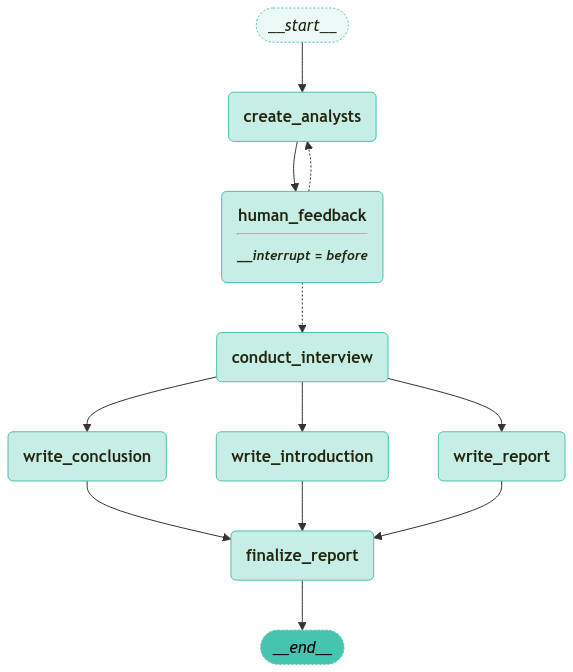

In [43]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START, END

# Create graph
builder = StateGraph(ResearchGraphState)

# Define nodes
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# Define edges
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"]
)

# Report generation from interviews
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")

# Final report assembly
builder.add_edge(
    ["write_conclusion", "write_report", "write_introduction"], "finalize_report"
)
builder.add_edge("finalize_report", END)

# Compile graph
memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# Visualize the workflow
visualize_graph(graph)

The graph structure implements:

**Core Workflow Stages**
- Analyst Creation
- Human Feedback Integration
- Parallel Interview Execution
- Report Generation
- Final Assembly

**Key Components**
- State Management using ResearchGraphState
- Memory persistence with MemorySaver
- Conditional routing based on human feedback
- Parallel processing of interviews
- Synchronized report assembly

**Flow Control**
- Starts with analyst creation
- Allows for human feedback and iteration
- Conducts parallel interviews
- Generates report components simultaneously
- Assembles final report with all components

This implementation creates a robust workflow for automated research with human oversight and parallel processing capabilities.

### Executing the Report Writing  Graph

 Here's how to run the graph with the specified parameters: 

In [44]:
# Set input parameters
max_analysts = 3
topic = "Explain how Modular RAG differs from traditional Naive RAG and the benefits of using it at the production level."

# Configure execution settings
config = RunnableConfig(
    recursion_limit=30,
    configurable={"thread_id": random_uuid()},
)

# Prepare input data
inputs = {"topic": topic, "max_analysts": max_analysts}

# Execute graph until first breakpoint
invoke_graph(graph, inputs, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='Tech Research Institute' name='Dr. Emily Wong' role='AI System Architect' description='Focuses on the architectural differences between Modular RAG and traditional Naive RAG, analyzing how modularity impacts system design and efficiency.'
affiliation='Data Science Consultancy' name='Mr. James Patel' role='Data Integration Specialist' description='Examines the benefits of Modular RAG in production environments, particularly in terms of integration flexibility and real-time data adaptability.'
affiliation='AI Ethics Foundation' name='Ms. Clara Johnson' role='Ethical AI Advocate' description='Concerned with the ethical implications of deploying Modular RAG in real-world applications, ensuring that modularity does not compromise ethical standards and data privacy.'

🔄 Node: __interrupt__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 


Let's add `human_feedback` to customize the analyst team and continue the graph execution:

In [45]:
# Add new analyst with human feedback
graph.update_state(
    config,
    {"human_analyst_feedback": "Add Prof. Jeffrey Hinton as a head of AI analyst"},
    as_node="human_feedback",
)

{'configurable': {'thread_id': '58fde4a4-a06a-433e-9dad-bdad40897347',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd8ceb-cfa8-67a4-8002-053a4bfb86cd'}}

In [46]:
# Continue graph execution
invoke_graph(graph, None, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='University of Toronto' name='Prof. Jeffrey Hinton' role='Head of AI Analyst' description='Prof. Hinton focuses on the foundational principles and future directions of AI models. He is particularly interested in how Modular RAG can enhance efficiency and scalability in AI systems compared to traditional Naive RAG, with an emphasis on production-level applications.'
affiliation='OpenAI' name='Dr. Emma Thompson' role='Scalability Expert' description='Dr. Thompson concentrates on the scalability aspects of AI models, examining how Modular RAG can be more efficiently scaled in production environments than traditional Naive RAG. She is motivated by improving model performance and reducing computational overhead.'
affiliation='DeepMind' name='Dr. Raj Patel' role='Efficiency Analyst' description='Dr. Patel is dedicated to analyzing the efficiency and optimization of AI architectures. His focus is on how 

Let's complete the human feedback phase and resume the graph execution: 

In [47]:
# End human feedback phase
graph.update_state(config, {"human_analyst_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '58fde4a4-a06a-433e-9dad-bdad40897347',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd8cec-034d-6c60-8004-b1efc8a67975'}}

In [48]:
# Resume graph execution
invoke_graph(graph, None, config)


🔄 Node: ask_question in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Hello, my name is Alex Carter, and I'm an analyst eager to delve deeper into the world of AI models. Thank you for taking the time to speak with me, Prof. Hinton. Let's start with the basics: Could you explain what Modular RAG is and how it fundamentally differs from traditional Naive RAG?

🔄 Node: ask_question in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Hello, my name is Alex Reed, and I'm an analyst exploring the intricacies of AI scalability. I'm very interested in understanding how Modular RAG differs from traditional Naive RAG and the benefits it offers, particularly in production environments. Dr. Thompson, could you elaborate on the key differences between Modular RAG and Naive RAG? Specifi

Here's how to display the final research report: 

In [49]:
from IPython.display import Markdown

# Get final graph state
final_state = graph.get_state(config)

# Retrieve final report
report = final_state.values.get("final_report")

# Display report in markdown format
display(Markdown(report))

# Enhancing AI Systems: The Modular RAG Advantage

## Introduction

In the dynamic landscape of artificial intelligence, the evolution of Retrieval-Augmented Generation (RAG) systems marks a pivotal advancement in the capabilities of Large Language Models (LLMs). Traditional Naive RAG systems laid the groundwork by integrating document retrieval with generative processes, facilitating the generation of contextually relevant outputs. However, as technological demands have grown, the limitations of Naive RAG—such as inefficiencies and a lack of adaptability—have become apparent. This report delves into the innovative Modular RAG approach, which offers a more efficient and scalable solution by employing a distributed multi-agent framework. This modular architecture allows for specialized agents optimized for specific data sources, enhancing query efficiency and improving response accuracy.

The analysis begins by examining the foundational aspects of Naive RAG systems, highlighting their strengths and inherent limitations. It then transitions into the advancements brought forth by Modular RAG, emphasizing its multi-agent design and the integration of autonomous AI agents that dynamically manage retrieval strategies. The report further explores the practical applications of Modular RAG in various industries, such as healthcare and finance, showcasing its scalability and adaptability at the production level. Finally, it addresses the challenges and future directions for Modular RAG systems, ensuring they meet ethical AI standards while continuing to evolve and integrate new technologies.

---

## Main Idea



### Background

Retrieval-Augmented Generation (RAG) systems are pivotal in enhancing Large Language Models (LLMs) by integrating real-time data retrieval with language generation. Traditionally, Naive RAG systems have laid the groundwork by providing a basic framework that uses retrieval mechanisms to rank the relevance of indexed data to an input query, followed by a generative component that synthesizes responses. This method, effective for simple question-answering tasks, ensures that AI-generated outputs are coherent and contextually relevant. However, the Naive RAG model's reliance on a single-agent architecture presents significant limitations, particularly in handling diverse datasets and dynamic environments, leading to performance bottlenecks and reduced accuracy [1][3][5].

The advent of Modular RAG systems marks a significant evolution in this domain. Unlike their Naive counterparts, Modular RAG systems employ a distributed multi-agent framework, where tasks are divided among specialized agents optimized for specific data sources, such as relational databases and document stores. This modularity allows for enhanced efficiency, scalability, and flexibility, making these systems well-suited for production-level applications [2][4]. By integrating autonomous AI agents that dynamically manage retrieval strategies and adapt workflows, Modular RAG systems achieve superior context-aware and accurate outputs across various fields, including healthcare, finance, and education [5].

Overall, the shift from Naive to Modular RAG systems represents a transformative development in AI, offering a robust solution for integrating LLMs into diverse applications, thereby paving the way for more precise, efficient, and reliable AI-driven insights [6].

### Related Work

The development of Modular RAG systems can be traced back to the foundational Naive RAG models, which established the basic integration of retrieval mechanisms with language generation processes. These systems, however, face challenges related to shallow query understanding and retrieval redundancy, leading to inefficiencies in data processing and increased noise in outputs [1][2]. Over time, advancements in RAG systems have focused on overcoming these limitations through innovative approaches such as modular architecture, dynamic retrieval strategies, and enhanced data integration techniques.

Recent studies highlight the transformative potential of Modular RAG systems in various applications. For instance, several research efforts have explored the introduction of token-level harmonization models, which balance the benefits of external data integration against the potential drawbacks of noise and misinformation [2]. Moreover, practical implementations of Modular RAG have demonstrated significant improvements in accuracy and contextual understanding, particularly in knowledge-intensive tasks and industrial settings [4].

Additionally, the use of sophisticated techniques such as dynamic embedding adjustment and routing mechanisms has been shown to enhance the precision and relevance of retrieved information, thereby improving the overall quality of generated responses [3][5]. Case studies in fields such as agriculture and healthcare further underscore the practical advantages of Modular RAG systems, showcasing their ability to integrate domain-specific knowledge effectively and provide actionable insights [1][3].

These advancements suggest a promising future for Modular RAG systems, as they continue to evolve and integrate new technologies to address the growing demands of AI applications.

### Problem Definition

The primary challenge addressed by the evolution from Naive to Modular RAG systems is the inefficiency and inflexibility inherent in the monolithic design of traditional RAG models. Naive RAG systems often struggle with complex queries due to their reliance on straightforward similarity metrics, leading to inaccurate or irrelevant retrievals. This limitation is exacerbated by the indiscriminate feeding of retrieved data into language models, which can introduce noise and increase computational overhead without necessarily enhancing output quality [1][3].

In dynamic environments where data sources and types vary significantly, the single-agent architecture of Naive RAG systems becomes a bottleneck, hindering their effectiveness and scalability. This issue is particularly critical in production-level applications that require real-time data integration and adaptability to new information or scenarios. The need for a more flexible, efficient, and scalable solution is evident across various domains, including healthcare, finance, and education, where precision and contextual relevance are paramount [2][5].

To address these challenges, a shift towards a Modular RAG framework is proposed. By decomposing the RAG architecture into independent, reconfigurable modules, this approach aims to enhance query efficiency, reduce processing overhead, and improve response accuracy. The introduction of autonomous AI agents within this modular framework further contributes to dynamic adaptability, ensuring that retrieval strategies and workflows are optimized to meet the complex requirements of diverse tasks [4][5].

### Methodology

The methodological advancements in Modular RAG systems focus on transforming the traditional RAG architecture into a more flexible and scalable framework. This transformation is achieved through the decomposition of the RAG system into independent modules, each responsible for specific tasks such as query generation, data retrieval, and response synthesis. This modular approach allows for targeted improvements and customization, enabling the system to adapt to specific tasks or domains without requiring an overhaul of the entire architecture [4][6].

A key aspect of this methodology is the integration of autonomous AI agents that employ agentic design patterns, such as reflection and planning, to dynamically manage retrieval strategies and adapt workflows. These agents iteratively refine contextual understanding, ensuring more accurate and context-aware responses across various applications [5]. Additionally, the use of advanced techniques such as dynamic embedding adjustment and routing mechanisms enhances the precision and relevance of the retrieved information, further improving the quality of generated responses [3][5].

The implementation of token-level harmonization models provides a theoretical framework for balancing the benefits of external data integration with the potential drawbacks of noise and misinformation. This model allows for estimation of RAG effects on token prediction, supporting data-driven improvements while minimizing detriments [2].

Overall, the methodology behind Modular RAG systems represents a significant leap forward, offering a robust solution for integrating LLMs into diverse applications and addressing the growing demands of AI-driven insights.

### Implementation Details

Implementing Modular RAG systems involves several key components and configurations that distinguish them from traditional Naive RAG models. The modular architecture is designed to facilitate reconfigurability and scalability, enabling each component to be independently modified or replaced as needed. This flexibility is essential for maintaining performance and adapting to new data or requirements in large-scale applications [4][6].

The deployment of autonomous AI agents within the Modular RAG framework is a critical aspect of its implementation. These agents are responsible for managing retrieval strategies and adapting workflows dynamically, leveraging agentic design patterns to ensure optimal performance across various tasks. The integration of advanced techniques such as dynamic embedding adjustment and routing mechanisms further enhances the system's efficiency and accuracy [5].

Additionally, the implementation of token-level harmonization models provides a theoretical basis for balancing external data integration with the potential drawbacks of noise and misinformation. This model supports data-driven improvements while minimizing detriments, ensuring that the system remains robust and reliable [2].

Practical implementations of Modular RAG systems have demonstrated their effectiveness in various domains, including healthcare, finance, and education. By integrating domain-specific knowledge and optimizing query pipelines, these systems provide actionable insights and enhance decision-making processes across diverse applications [1][3]. The modular nature of these systems also facilitates compliance with ethical AI standards, ensuring that they can be tailored to meet specific regulatory requirements and performance benchmarks [5].

### Experiments

The experimental validation of Modular RAG systems involves a comprehensive evaluation of their performance across various datasets and applications. These experiments are designed to assess the effectiveness of the modular architecture and the integration of autonomous AI agents in enhancing query efficiency, response accuracy, and overall scalability [4][6].

A key focus of these experiments is the comparison of Modular RAG systems with traditional Naive RAG models. By evaluating the systems' ability to handle complex queries, integrate real-time data, and adapt to diverse environments, researchers can quantify the improvements offered by the modular approach. Metrics such as retrieval precision, response accuracy, and computational overhead are commonly used to assess performance [1][3].

The implementation of token-level harmonization models provides additional insights into the balance between external data integration and potential drawbacks such as noise and misinformation. These models are evaluated for their predictive capability and their ability to support data-driven improvements while minimizing detriments [2].

Case studies in fields such as agriculture and healthcare further demonstrate the practical advantages of Modular RAG systems. By incorporating domain-specific knowledge and leveraging advanced retrieval strategies, these systems provide actionable insights and enhance decision-making processes in real-world applications [1][3]. The results of these experiments underscore the potential of Modular RAG systems to transform AI applications by enhancing scalability, adaptability, and efficiency.

### Results

The results of experiments and case studies on Modular RAG systems consistently demonstrate their superiority over traditional Naive RAG models in terms of efficiency, accuracy, and scalability. By decomposing the RAG architecture into independent modules, Modular RAG systems achieve significant improvements in query efficiency and response accuracy, reducing processing overhead and enhancing overall performance [4][6].

The integration of autonomous AI agents within the Modular RAG framework further contributes to these improvements. By dynamically managing retrieval strategies and adapting workflows, these agents ensure that the system remains context-aware and responsive to complex task requirements. This adaptability is particularly beneficial in applications that require real-time data integration and precision, such as healthcare, finance, and education [5].

The implementation of token-level harmonization models provides additional support for these findings, highlighting the balance between external data integration and potential drawbacks such as noise and misinformation. These models enhance the reliability and accuracy of the system's outputs, supporting data-driven improvements without compromising performance [2].

Case studies in various domains further validate the practical advantages of Modular RAG systems. In agriculture, these systems provide geographic-specific insights, enhancing decision-making processes for farmers. In healthcare, they improve the accuracy and reliability of question-answering systems for cancer patients, optimizing query pipelines and leveraging domain-specific databases [1][3].

Overall, the results of these studies underscore the transformative potential of Modular RAG systems, offering a robust solution for integrating LLMs into diverse applications and addressing the growing demands of AI-driven insights.

### Sources
[1] https://www.superteams.ai/blog/how-to-implement-naive-rag-advanced-rag-and-modular-rag  
[2] https://zilliz.com/blog/advancing-llms-native-advanced-modular-rag-approaches  
[3] https://adasci.org/how-does-modular-rag-improve-upon-naive-rag/  
[4] http://arxiv.org/abs/2407.21059v1  
[5] http://arxiv.org/abs/2501.09136v1  
[6] https://medium.com/@sahin.samia/modular-rag-using-llms-what-is-it-and-how-does-it-work-d482ebb3d372

---

## Conclusion

In the rapidly evolving landscape of AI technology, the shift from Naive RAG to Modular RAG frameworks marks a significant advancement in optimizing the performance and scalability of Retrieval-Augmented Generation systems. This report has thoroughly examined the comparative benefits of Modular RAG, underscoring its ability to address the inefficiencies inherent in Naive RAG systems. Naive RAG’s foundational architecture, while pivotal, struggles with inflexibility and processing bottlenecks, limiting its effectiveness in dynamic environments.

Modular RAG introduces a multi-agent, distributed framework that enhances efficiency through specialized agents optimized for diverse data sources. This modularity allows for refined query processes, reduced overhead, and improved accuracy, as each agent focuses on specific tasks within the framework. The integration of autonomous AI agents further advances this system by dynamically adapting retrieval strategies to meet complex task requirements, thereby ensuring more context-aware and accurate outputs.

Applications across various industries, such as healthcare and finance, demonstrate Modular RAG's scalability and adaptability in production environments, offering real-time data integration and enhanced decision-making capabilities. However, the challenges of modular interactions and ethical considerations remain areas for future exploration. Continued research and development will be essential to fully realize the potential of Modular RAG systems, paving the way for more robust and efficient AI applications that can adapt to the ever-changing demands of real-world scenarios.

In [50]:
print(report)

# Enhancing AI Systems: The Modular RAG Advantage

## Introduction

In the dynamic landscape of artificial intelligence, the evolution of Retrieval-Augmented Generation (RAG) systems marks a pivotal advancement in the capabilities of Large Language Models (LLMs). Traditional Naive RAG systems laid the groundwork by integrating document retrieval with generative processes, facilitating the generation of contextually relevant outputs. However, as technological demands have grown, the limitations of Naive RAG—such as inefficiencies and a lack of adaptability—have become apparent. This report delves into the innovative Modular RAG approach, which offers a more efficient and scalable solution by employing a distributed multi-agent framework. This modular architecture allows for specialized agents optimized for specific data sources, enhancing query efficiency and improving response accuracy.

The analysis begins by examining the foundational aspects of Naive RAG systems, highlighting their 